#Importing libraries and running functions

In [1]:
#Here we import some necessary libraries. Please, run this cell.
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.optimize as opt
import statsmodels.formula.api as smf
import statistics
import itertools
import math
import random
warnings.filterwarnings("ignore")

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from scipy.optimize import OptimizeResult
from sklearn.linear_model import QuantileRegressor
from tqdm import tqdm

In [2]:
#Here are all the functions that I use below

#This function makes a simple check of validity of the dataset
def filecheck(dataset):#filename):
    flag = 0
    date = dataset['DATE']
    prcp = dataset['PRCP']
    #date1 = date[-36500:]
    ind = -1
    flag_nan = True
    while flag_nan:
       ind += 1
       flag_nan = np.isnan(prcp[ind])
    date_start = date[ind]
    len1 = len(date)
    date_end = date[len(date)-1]
    len1 = len1 - ind

    prcp = prcp[ind:]
    a = 365*(int(date_end[0:4]) - int(date_start[0:4])) + 30*(int(date_end[5:7]) - int(date_start[5:7])) + (int(date_end[8:10]) - int(date_start[8:10]))
    len_prcp = len(prcp[np.isnan(prcp)])

    if (int(date_start[0:4]) < 1923) & (a/len1<368/365) & (len_prcp/len1 < 3/365):
        ind = 0
        #while ind<
    else:
        flag = 1
    return flag, a/len1, len_prcp/len1, date_start, date_end

#This function checks if there are less than 5 nans and missed values of precipitation per year and returns the longest row of such years
def prcp_check(dataset):
    date = dataset['DATE']
    prcp = dataset['PRCP']
    len_date = len(date)
    ind = len_date-2
    final_year_temp = int(date[len_date-1][0:4])
    first_year_temp = final_year_temp
    final_year = final_year_temp
    first_year = first_year_temp

    flag = 1
    while (ind >= 0):
      ind += 1
      ind_0 = ind
      while ((date[ind][0:4] == date[ind_0][0:4]) & (ind_0 > 0)):
         ind_0 -= 1
      if (ind != len_date-1):
         prcp_temp = prcp[ind_0+1:ind+1]
         if (365 - ind + ind_0 + len(prcp_temp[np.isnan(prcp_temp)])>4):
            flag = 0
            first_year_temp = int(date[ind][0:4])
      if (flag == 0):
         if ((final_year_temp - first_year_temp) > (final_year - first_year)):
            final_year = final_year_temp
            first_year = first_year_temp + 1
         final_year_temp = first_year_temp - 1
         first_year_temp = final_year_temp
         flag = 1
      ind = ind_0-1

    #if (final_year - first_year > 100):
    return first_year, final_year
    #else:
    #  return 'bad, very bad dataset'

#This function just transforms day-month to the number of the day in the year
def month_day_to_number(month, day):
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    mask = np.ones(12)
    mask[month-1:] *= 0
    return (np.array(mask)*np.array(days_in_month)).sum() + day

#These three functions are needed to apply my test for distinguishing between classes of distribution tails

def quantile_LW_Pareto(n, k, glob):
  q = np.log(np.log(n/k))
  r = np.sqrt(glob**2 + 4*q)
  return np.exp(np.exp(((r - glob)/2)**2))

def quantile_W_LW(n, k, glob):
  return np.exp((np.log(np.log(n/k)))**2/glob)

def quantile_RV_W(n, k, glob):
  return np.exp(np.sqrt(np.log(n/k)/glob))

def test_statistic(n, k_n, samples, glob, method):

    const_log = np.log(n*1./k_n)

    if method == "LW_Pareto":
      #usually glob = 1.1 in this case
      const_quant = quantile_LW_Pareto(n, k_n, glob)
      const_quant2 = quantile_LW_Pareto(n, 2*k_n, glob)

      def locscale_LW_Pareto(x):
        t = (x - samples[n-k_n])/(samples[n-k_n] - samples[n-2*k_n])*(const_quant - const_quant2) + const_quant
        return np.exp(glob*np.sqrt(np.log(np.log(t))))*np.log(t) - const_log

      tmp = np.sum(locscale_LW_Pareto(np.array(samples[n-k_n:n])))

    elif method == "W_LW":
      #usually glob \in [3; 4] in this case
      const_quant = quantile_W_LW(n, k_n, glob)
      const_quant2 = quantile_W_LW(n, 2*k_n, glob)

      def locscale_W_LW(x):
        t = (x - samples[n-k_n])/(samples[n-k_n] - samples[n-2*k_n])*(const_quant - const_quant2) + const_quant
        return np.exp(np.sqrt(glob*abs(np.log(t)))) - const_log

      tmp = np.sum(locscale_W_LW(np.array(samples[n-k_n:n])))

    elif method == "RV_W":
      #usual value for glob is 0.4
      const_quant = quantile_RV_W(n, k_n, glob)
      const_quant2 = quantile_RV_W(n, 2*k_n, glob)

      def locscale_RV_W(x):
        t = (x - samples[n-k_n])/(samples[n-k_n] - samples[n-2*k_n])*(const_quant - const_quant2) + const_quant
        return glob*np.power(np.log(t),2) - const_log

      tmp = np.sum(locscale_RV_W(np.array(samples[n-k_n:n])))

    return 1/np.sqrt(k_n)*(tmp - k_n)

#Some necessary functions to apply block quantiles method and classical methods for tail estimation
def block_maxima(sample, number_of_blocks):

    n = len(sample)
    length = n // number_of_blocks
    #length = number_of_blocks
    sample_new = list(map(lambda x: np.max(sample[int(length*x):int(length*(x+1))]), range(number_of_blocks)))

    return sample_new
################################################################################
def generate_model(sample, alpha_min, alpha_max, block_min, block_max, number_block, ratio, threshold, is_threshold = True):

    if is_threshold:
      sample = sample[sample>threshold] - threshold
    n = len(sample)

    #block_size = list(map(lambda x: block_min + int(x*(block_max - block_min)/(number_block-1)), range(number_block)))
    block_size = list(map(lambda x: int(block_min*np.power((block_max - block_min), x/(number_block-1))), range(number_block-1)))
    #alphas = list(map(lambda x: alpha_min + x*(alpha_max - alpha_min)/(number_alpha-1), range(number_alpha)))

    feature = []
    target = []
    index = 0

    for i in block_size:
        n_temp = n // i
        alphas = []
        sample_temp = block_maxima(sample, n_temp)
        #sample_temp = block_maxima(sample, i)
        sample_temp = sorted(sample_temp)

        for j in range(n_temp):
          if (j >= alpha_min*n_temp)&(j <= alpha_max*n_temp):
            alphas.append(j)

        alphas = list(alphas)
        #feature_temp = list(map(lambda x: 1 - np.power(x, 1/n_temp), alphas))
        feature[index:index+len(alphas)] = list(map(lambda x: (1 - np.power(x/n_temp, 1/i)), alphas))
        #target[j*number_alpha:(j+1)*number_alpha] = list(map(lambda x: sample_temp[int(x*n_temp-1)], alphas))
        target[index:index+len(alphas)] = list(map(lambda x: sample_temp[x-1], alphas))
        #list(map(lambda x: sample_temp[int(x*n_temp-1)]*((x*n_temp) % 1) + sample_temp[int(x*n_temp)]*(1 - ((x*n_temp) % 1)), alphas))
        index = index+len(alphas)

    return feature, target
################################################################################
def quantile_of_maxima(evi, sigma, ratio, threshold, level, n):
    return threshold + np.exp(sigma)*np.power((1 - np.power(level, 1/n)), evi)
################################################################################
def quantile_classical(evi, sigma, theta, ratio, threshold, level, n):
    if evi != 0:
      return threshold + (np.power((1 - np.power(level, 1/(n*theta)))/ratio, -evi) - 1)*sigma/evi
    else:
      return threshold - np.log((1 - np.power(level, 1/(n*theta)))/ratio)*sigma
################################################################################
def quantile_trivial(evi, sigma, level, n):
    return np.exp(sigma + evi*np.log(1 - np.power(level, 1/n)))
################################################################################
def quantile_logweibull(theta, scale, location, level, n):
    return location + scale*np.exp(np.power(-np.log(1 - np.power(level, 1/n)), theta))
################################################################################
def quantile_logweibull_trivial(theta, sigma, level, n):
    return np.exp(sigma*np.power(-np.log(1 - np.power(level, 1/n)), theta))
################################################################################
def quantile_weibull(theta, scale, location, level, n):
    return location + scale*np.power(-np.log(1 - np.power(level, 1/n)), theta)
################################################################################
def quantile_weibull_trivial(theta, sigma, level, n):
    return sigma*np.power(-np.log(1 - np.power(level, 1/n)), theta)
################################################################################
def quantile_gev(evi, scale, location, theta, level, n):
    return location + scale*(-1 + np.power(-np.log(level)/n/theta, -evi))/evi
################################################################################
def hill_estimator(sample, ratio):
    sample = sorted(sample)
    n = len(sample)
    return np.mean(np.log(sample[int(n*(1-ratio)):])) - np.log(sample[int(n*(1-ratio))-1])
################################################################################
def moment(sample, ratio, power):
    sample = sorted(sample)
    n = len(sample)
    threshold = sample[int(n*(1-ratio))-1]
    return np.mean(np.power(np.log(sample[int(n*(1-ratio)):]) - np.log(threshold), power))
################################################################################
def moment_estimator(sample, ratio):
    hill = hill_estimator(sample, ratio)
    second_moment = moment(sample, ratio, 2)
    return hill + 1 - 0.5*second_moment/(second_moment - np.power(hill, 2))
################################################################################
def second_order(sample, ratio, tau):
    sample = sorted(sample)
    n = len(sample)
    m1 = hill_estimator(sample, ratio)
    m2 = moment(sample, ratio, 2)
    m3 = moment(sample, ratio, 3)
    t = (np.power(m1, tau) - np.power(m2/2, tau/2))/(np.power(m2/2, tau/2) - np.power(m3/6, tau/3))
    return -3*np.abs((t-1)/(t-3))
################################################################################
def mle_estimator(sample, ratio):
    sample = sorted(sample)
    n = len(sample)
    threshold = sample[int(n*(1 - ratio))]
    return ss.genpareto.fit(np.array(sample[int(n*(1 - ratio))+1:]) - threshold, floc = 0)
################################################################################
def sigma_estimator(sample, ratio):

    sample = sorted(sample)
    n = len(sample)
    gamma = hill_estimator(sample, ratio)
    high_level = sample[int(n*(1-ratio))-1]

    ran = range(int(n*ratio))
    m_2n = 0
    for i in ran:
       m_2n += (np.log(sample[int(n-i-1)]) - np.log(high_level))**2/int(n*ratio)
    #m_2n = np.mean(list(map(lambda x: np.power(np.log(sample[int(x)]/high_level), 2), np.arange(int(n*(1-ratio)), n, 1))))
    gamma_minus = 1 - 0.5*m_2n/(m_2n - gamma**2)

    return high_level*gamma*(1-gamma_minus)
################################################################################
def intervals_estimator(sample, ratio):
    d = {'index': range(len(sample)), 'sample': sample}
    sam = pd.DataFrame(d)
    n = len(sample)
    sorted_sample = sorted(sample)
    high_level = sorted_sample[int(n*(1-ratio))-1]

    indices = list(sam['index'][sam['sample']>high_level])
    inter_exceed = list(map(lambda x: indices[int(x+1)] - indices[int(x)], range(len(indices)-1)))
    L = len(inter_exceed)

    num = 2*np.power(np.sum(inter_exceed) - L, 2)
    denom = L*np.sum(list(map(lambda x: (inter_exceed[x]-1)*(inter_exceed[x]-2), range(L))))

    if ((denom>0) & (num/denom<1)):
      return num/denom
    else:
      return 1
################################################################################
def pwm_estimator(sample, block_size, method):
    lensample = len(sample)
    number_of_blocks = lensample//block_size
    if method == "disjoint":
      sample_maxima = block_maxima(sample, number_of_blocks)
    elif method == "sliding":
      sample_maxima = []
      for i in range(block_size):
        number_of_blocks = (lensample-i)//block_size
        sample_maxima = np.append(sample_maxima, block_maxima(sample[i:], number_of_blocks))
      sample_maxima = np.array(list(sample_maxima))

    sample_maxima = sorted(sample_maxima)
    lensample = len(sample_maxima)
    beta_0 = np.mean(sample_maxima)
    beta_1 = np.mean(np.array(list(map(lambda x: x*sample_maxima[x]/(lensample-1), range(lensample)))))
    beta_2 = np.mean(np.array(list(map(lambda x: x*(x-1)*sample_maxima[x]/(lensample-1)/(lensample-2), range(lensample)))))

    def func(gamma):
      first_ratio = (np.power(3, gamma)-1)/(np.power(2, gamma)-1)
      second_ratio = (3*beta_2 - beta_0)/(2*beta_1 - beta_0)
      return np.abs(first_ratio - second_ratio)

    gamma = np.array([1])
    res_gamma = opt.minimize(func, gamma)
    gamma = res_gamma.x[0]
    gamma_function = math.gamma(1-gamma)
    sigma = gamma*(2*beta_1 - beta_0)/gamma_function/(np.power(2,gamma)-1)
    mu = beta_0 + sigma*(1 - gamma_function)/gamma

    return gamma, sigma, mu
############################################################################3333
def adam(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.005,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    startiter=0,
    maxiter=1000,
    callback=None,
    **kwargs
):
    """``scipy.optimize.minimize`` compatible implementation of ADAM -
    [http://arxiv.org/pdf/1412.6980.pdf].
    Adapted from ``autograd/misc/optimizers.py``.
    """
    x = x0
    m = np.zeros_like(x)
    v = np.zeros_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        m = (1 - beta1) * g + beta1 * m  # first  moment estimate.
        v = (1 - beta2) * (g**2) + beta2 * v  # second moment estimate.
        mhat = m / (1 - beta1**(i + 1))  # bias correction.
        vhat = v / (1 - beta2**(i + 1))
        x = x - learning_rate * mhat / (np.sqrt(vhat) + eps)

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)
################################################################################
def eye_ball(sample, method):
    length = len(sample)
    len_pos = len(sample[sample>0])
    window = int(0.01*length)
    epsilon = 0.3
    ratio = 0.9
    hill_list = np.array(list(map(lambda x: method(sample, (x+1)/length), range(window+1))))

    flag = 0
    t = hill_list[flag]
    indi = len(hill_list[abs(1/hill_list - 1/t)<epsilon])/window

    while indi<ratio:
      flag += 1
      hill_list = np.append(hill_list, method(sample, (window+1+flag)/length))
      temp = hill_list[flag:]
      t = temp[0]
      indi = len(temp[abs(1/temp - 1/t)<epsilon])/window
      if flag == len_pos - window - 1:
        break

    return (flag+1)/length #hill_list[flag]#, sigma_estimator(sample, (flag+1)/length)
################################################################################
def eye_ball_sigma(sample):
    length = len(sample)
    len_pos = len(sample[sample>0])
    window = int(0.01*length)
    epsilon = 0.3
    ratio = 0.9
    hill_list = np.array(list(map(lambda x: sigma_estimator(sample, (x+1)/length), range(window+1))))

    flag = 0
    t = hill_list[flag]
    indi = len(hill_list[abs(1/hill_list - 1/t)<epsilon])/window

    while indi<ratio:
      flag += 1
      hill_list = np.append(hill_list, sigma_estimator(sample, (window+1+flag)/length))
      temp = hill_list[flag:]
      t = temp[0]
      indi = len(temp[abs(1/temp - 1/t)<epsilon])/window
      if flag == len_pos - window - 1:
        break

    return (flag+1)/length
################################################################################
def Kgaps_estimator(ser):
    N_C = len(ser[ser>0])
    L = len(ser)
    a = L - N_C
    b = 2*N_C
    c = np.sum(ser[ser>0])
    f = (a+b)/c + 1
    return 0.5*(f - np.sqrt(np.square(f) - 4*b/c))
################################################################################
def omega_squared(ser, k, K, level):
    ser = np.array(sorted(ser))
    L = len(ser)
    sernew = np.array(list(map(lambda x: np.max((ser[x] - K)*(1-level), 0), range(L))))

    stat = sernew[L-k-1]
    theta = Kgaps_estimator(sernew)

    temp = np.array(list(map(lambda x: np.square(np.exp((stat - sernew[L-x-1])*theta) - (x+0.5)/k), range(k))))
    return np.sum(temp) + 1/(k*12), theta
################################################################################
def algorithm_discrepancy(sample, level):
    sort = sorted(sample)
    length = len(sample)
    threshold = sort[int(length*level)]

    # first step
    ser = pd.Series(sample)
    exc = np.array(ser[ser>threshold].index)
    L = len(exc) - 1
    interexceedances = np.array(list(map(lambda x: exc[x+1] - exc[x], range(L))))

    # second step
    k = int(L*intervals_estimator(sample, 1-level))

    # third step
    sum_thetas = 0
    flag = 0
    if (k > 20):
      for i in range(21):
        a, b = omega_squared(interexceedances, k, i, level)
        if a < 1.49:
          sum_thetas += b
        flag += 1

    return sum_thetas, flag
################################################################################
def discrepancy(sample):
    alphas = np.arange(0.9, 1, 0.005)
    t = 0
    st = 0

    for alpha in alphas:
      temp1, temp2 = algorithm_discrepancy(sample, alpha)
      t += temp2
      st += temp1

    if (t > 0):
      return st/t
    else:
      return intervals_estimator(sample, 0.1)
################################################################################
def MLE_Weibull3(sample, ratio, method):
    sample = sorted(sample)
    sample_max = np.array(sample[int(len(sample)*(1-ratio))+1:])
    threshold = sample[int(len(sample)*(1-ratio))]
    k = len(sample_max)

    def loglikelihood(x):
        first_sum = np.sum(np.log((sample_max-x[0])/x[1]))
        second_sum = np.sum(np.power((sample_max-x[0])/x[1], x[2]))
        return -k*(np.log(x[2]/x[1])) - (x[2]-1)*first_sum + second_sum - k*np.power((threshold-x[0])/x[1], x[2])

    #if method == 'Cobyla':
    z = np.array([1., 1., 1.])
    res = opt.minimize(loglikelihood, z, method = 'COBYLA')

    return res.x
################################################################################
def MLE_logWeibull3(sample, ratio, method):
    sample = sorted(sample)
    sample_max = np.array(sample[int(len(sample)*(1-ratio))+1:])
    threshold = sample[int(len(sample)*(1-ratio))]
    k = len(sample_max)

    def loglikelihood(x):
        zero_sum = np.sum(np.log(sample_max - x[0]))
        first_sum = np.sum(np.log(np.log((sample_max-x[0])/x[1])))
        second_sum = np.sum(np.power(np.log((sample_max-x[0])/x[1]), x[2]))
        return -k*(np.log(x[2])) + zero_sum - (x[2]-1)*first_sum + second_sum - k*np.power(np.log((threshold-x[0])/x[1]), x[2])

    #if method == 'Cobyla':
    z = np.array([100., 1., 1.])
    res = opt.minimize(loglikelihood, z, method = 'COBYLA')

    return res.x
################################################################################
def MLE_logWeibull2(sample, ratio, method):
    sample = sorted(sample)
    sample_max = np.array(sample[int(len(sample)*(1-ratio))+1:])
    sample_std = sample_max.std()
    sample_max = sample_max/sample_std
    threshold = sample[int(len(sample)*(1-ratio))]/sample_std
    k = len(sample_max)

    def loglikelihood(x):
        zero_sum = np.sum(np.log(sample_max - threshold + x[0]))
        first_sum = np.sum(np.log(np.log((sample_max-threshold + x[0])/x[0])))
        second_sum = np.sum(np.power(np.log((sample_max-threshold+x[0])/x[0]), x[1]))
        return -k*(np.log(x[1])) + zero_sum - (x[1]-1)*first_sum + second_sum

    #if method == 'Cobyla':
    z = np.array([1.1, 1.1])
    res = opt.minimize(loglikelihood, z, method = 'COBYLA')

    return res.x[0]*sample_std, res.x[1]
################################################################################
def CvM(x,y):
  res = ss.cramervonmises_2samp(x, y)
  return res.statistic#, res.pvalue
################################################################################
def LS(feature, target, method, N, alphas):

    target = np.array(target)
    feature = np.array(feature)
    mintarget = target.min() - math.e - 1
    target -= mintarget
    d1 = {'target': target, 'feature': feature}
    data2 = pd.DataFrame(d1)

    if method == 'W':
        m = smf.ols('np.log(target) ~ np.log(-np.log(feature))', data=data2)
        mfit = m.fit()
        quantiles = np.array(list(map(lambda x: quantile_weibull_trivial(mfit.params[1], np.exp(mfit.params[0]), x, N), alphas)))+mintarget
    elif method == 'LW':
        m = smf.ols('np.log(np.log(target)) ~ np.log(-np.log(feature))', data=data2)
        mfit = m.fit()
        quantiles = np.array(list(map(lambda x: quantile_logweibull_trivial(mfit.params[1], np.exp(mfit.params[0]), x, N), alphas))) + mintarget
    elif method == 'RV':
        m = smf.ols('np.log(target) ~ np.log(feature)', data=data2)
        mfit = m.fit()
        quantiles = np.array(list(map(lambda x: quantile_trivial(mfit.params[1], mfit.params[0], x, N), alphas))) + mintarget

    #return quantiles, mfit.params[1]
    return quantiles, mfit.params[0], mfit.params[1]
################################################################################
def Theil(feature, target, method, N, alphas):

    target = np.array(target)
    feature = np.array(feature)
    mintarget = target.min() - math.e - 1.0
    target -= mintarget

    if method == 'W':
        x = np.log(-np.log(feature))
        y = np.log(target)
    elif method == 'LW':
        x = np.log(-np.log(feature))
        y = np.log(np.log(target))
    elif method == 'RV':
        x = np.log(feature)
        y = np.log(target)

    #diff = []
    #for k in range(len(x)):
    #  for j in range(k+1, len(x)):
    #    diff.append((y[k] - y[j])/(x[k] - x[j]))

    evi_theil, sigma_theil, a, b = ss.theilslopes(y, x, alpha=0.95, method='joint')

    #evi_theil = statistics.median(diff)
    #sigma_theil = statistics.median(y - evi_theil*x)

    if method == 'W':
        quantiles = np.array(list(map(lambda x: quantile_weibull_trivial(evi_theil, np.exp(sigma_theil), x, N), alphas))) + mintarget
    elif method == 'LW':
        quantiles = np.array(list(map(lambda x: quantile_logweibull_trivial(evi_theil, np.exp(sigma_theil), x, N), alphas))) + mintarget
    elif method == 'RV':
        quantiles = np.array(list(map(lambda x: quantile_trivial(evi_theil, sigma_theil, x, N), alphas))) + mintarget

    #return quantiles, evi_theil
    return quantiles, sigma_theil, evi_theil
################################################################################
def Cobyla(feature, target, method, N, alphas, starting_theta):

    target = np.array(target)
    target_mean = target.mean()
    target_std = target.std()
    target = (target - target_mean)/target_std
    target_min = target.min()-1

    if method == 'W_s':
      def func(x):
        feature1 = np.power(-np.log(np.array(feature)), x[0])
        feature_mean = feature1.mean()
        feature_std = feature1.std()
        feature1 = (feature1 - feature_mean)/feature_std
        return np.sum(np.square(target - x[2] - x[1]*feature1))
      z = np.array([starting_theta, 1., 0.])
    elif method == 'W':
      def func(x):
        return np.sum(np.square(target - x[2] - x[1]*np.power(-np.log(feature), x[0])))
    elif method == 'LW':
      def func(x):
        return np.sum(np.square(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))))
    elif method == 'RV':
      def func(x):
        return np.sum(np.square(target - x[2] - x[1]*np.power(feature, - x[0])))

    #z = np.array([1., 1., target_min])
    #z = np.array([starting_theta, 1., -1.])
    z = np.array([starting_theta, 1., -1.])
    res = opt.minimize(func, z, method='COBYLA')

    if method == 'W_s':
        feature1 = np.power(-np.log(np.array(feature)), res.x[0])
        feature_mean = feature1.mean()
        feature_std = feature1.std()
        quantiles = list(map(lambda y: quantile_weibull(res.x[0], res.x[1]*target_std/feature_std, res.x[2]*target_std + target_mean - res.x[1]*target_std*feature_mean/feature_std, y, N), alphas))
    elif method == 'W':
        quantiles = list(map(lambda y: quantile_weibull(res.x[0], res.x[1]*target_std, res.x[2]*target_std + target_mean, y, N), alphas))
    elif method == 'LW':
        quantiles = list(map(lambda y: quantile_logweibull(res.x[0], res.x[1]*target_std, res.x[2]*target_std + target_mean, y, N), alphas))
    elif method == 'RV':
        quantiles = list(map(lambda y: quantile_of_maxima(-res.x[0], np.log(res.x[1]*target_std), 1, res.x[2]*target_std + target_mean, y, N), alphas))

    return quantiles, res.x
################################################################################
def Adam(feature, target, method, N, alphas, starting_theta, rho):

    target = np.array(target)
    #target_std = 1
    #target_mean = 0
    #For tail estimation it is important!
    target_mean = target.mean()
    target_std = target.std()
    target = (target - target_mean)/target_std
    target_min = target.min()-1.

    if method == 'W':
      def func(x):
        return np.sum(np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho))/rho

      def gradient(x):
        d = np.zeros(3)
        d[0] = - np.sum(np.sign(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))*x[1]*np.power(-np.log(feature), x[0])*np.log(-np.log(feature))*np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho-1))
        d[1] = - np.sum(np.sign(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))*np.power(-np.log(feature), x[0])*np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho-1))
        d[2] = - np.sum(np.sign(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))*np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho-1))
        return d

    elif method == 'LW':
      def func(x):
        return np.sum(np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho))/rho

      def gradient(x):
        d = np.zeros(3)
        d[0] = - np.sum(np.sign(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))*x[1]*np.exp(np.power(-np.log(feature), x[0]))*np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho-1)*np.exp(np.power(-np.log(feature), x[0]))*np.power(-np.log(feature), x[0])*np.log(-np.log(feature)))
        d[1] = - np.sum(np.sign(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))*np.exp(np.power(-np.log(feature), x[0]))*np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho-1))
        d[2] = - np.sum(np.sign(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))*np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho-1))
        return d

    elif method == 'RV':
      def func(x):
        return np.sum(np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho))/rho

      def gradient(x):
        d = np.zeros(3)
        d[0] = np.sum(np.sign(target - x[2] - x[1]*np.power(feature, - x[0]))*x[1]*np.power(feature, - x[0])*np.log(feature)*np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho-1))
        d[1] = - np.sum(np.sign(target - x[2] - x[1]*np.power(feature, - x[0]))*np.power(feature, - x[0])*np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho-1))
        d[2] = - np.sum(np.sign(target - x[2] - x[1]*np.power(feature, - x[0]))*np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho-1))
        return d

    #z = np.array([starting_theta, 1., 0])
    z = np.array([starting_theta, 1., -1])
    #z = np.array([1., 1., -1.])
    res = opt.minimize(func, z, jac = gradient, method=adam)
    resx = np.zeros(3)
    resx[0] = res.x[0]
    resx[1] = res.x[1]*target_std
    resx[2] = res.x[2]*target_std + target_mean

    if method == 'W':
        quantiles = list(map(lambda y: quantile_weibull(res.x[0], res.x[1]*target_std, res.x[2]*target_std + target_mean, y, N), alphas))
    elif method == 'LW':
        quantiles = list(map(lambda y: quantile_logweibull(res.x[0], res.x[1]*target_std, res.x[2]*target_std + target_mean, y, N), alphas))
    elif method == 'RV':
        quantiles = list(map(lambda x: quantile_of_maxima(-res.x[0], np.log(res.x[1]*target_std), 1, res.x[2]*target_std + target_mean, x, N), alphas))
    return quantiles, resx
################################################################################
def Adam1(feature, target, method, N, alphas, starting_theta, starting_b, rho):

    target = np.array(target)
    #target_std = 1
    #target_mean = 0
    #For tail estimation it is important!
    target_mean = target.mean()
    target_std = target.std()
    target = (target - target_mean)/target_std
    target_min = target.min()-1.

    if method == 'W':
      def func(x):
        return np.sum(np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho))/rho

      def gradient(x):
        d = np.zeros(3)
        d[0] = - np.sum(np.sign(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))*x[1]*np.power(-np.log(feature), x[0])*np.log(-np.log(feature))*np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho-1))
        d[1] = - np.sum(np.sign(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))*np.power(-np.log(feature), x[0])*np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho-1))
        d[2] = - np.sum(np.sign(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))*np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho-1))
        return d

    elif method == 'LW':
      def func(x):
        return np.sum(np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho))/rho

      def gradient(x):
        d = np.zeros(3)
        d[0] = - np.sum(np.sign(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))*x[1]*np.exp(np.power(-np.log(feature), x[0]))*np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho-1)*np.exp(np.power(-np.log(feature), x[0]))*np.power(-np.log(feature), x[0])*np.log(-np.log(feature)))
        d[1] = - np.sum(np.sign(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))*np.exp(np.power(-np.log(feature), x[0]))*np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho-1))
        d[2] = - np.sum(np.sign(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))*np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho-1))
        return d

    elif method == 'RV':
      def func(x):
        return np.sum(np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho))/rho

      def gradient(x):
        d = np.zeros(3)
        d[0] = np.sum(np.sign(target - x[2] - x[1]*np.power(feature, - x[0]))*x[1]*np.power(feature, - x[0])*np.log(feature)*np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho-1))
        d[1] = - np.sum(np.sign(target - x[2] - x[1]*np.power(feature, - x[0]))*np.power(feature, - x[0])*np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho-1))
        d[2] = - np.sum(np.sign(target - x[2] - x[1]*np.power(feature, - x[0]))*np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho-1))
        return d

    z = np.array([starting_theta, starting_b, 0])
    #z = np.array([1., 1., -1.])
    res = opt.minimize(func, z, jac = gradient, method=adam)
    resx = np.zeros(3)
    resx[0] = res.x[0]
    resx[1] = res.x[1]*target_std
    resx[2] = res.x[2]*target_std + target_mean

    if method == 'W':
        quantiles = list(map(lambda y: quantile_weibull(res.x[0], res.x[1]*target_std, res.x[2]*target_std + target_mean, y, N), alphas))
    elif method == 'LW':
        quantiles = list(map(lambda y: quantile_logweibull(res.x[0], res.x[1]*target_std, res.x[2]*target_std + target_mean, y, N), alphas))
    elif method == 'RV':
        quantiles = list(map(lambda x: quantile_of_maxima(-res.x[0], np.log(res.x[1]*target_std), 1, res.x[2]*target_std + target_mean, x, N), alphas))

    return quantiles, resx
################################################################################
def QuantLS(feature, target, method, level, N, alphas):

    target = np.array(target)
    feature = np.array(feature)
    mintarget = target.min() - math.e - 1
    target -= mintarget
    d1 = {'target': target, 'feature': feature}
    data2 = pd.DataFrame(d1)

    if method == 'W':
        m = smf.quantreg('np.log(target) ~ np.log(-np.log(feature))', data=data2)
        mfit = m.fit(q = level)
        quantiles = np.array(list(map(lambda x: quantile_weibull_trivial(mfit.params[1], np.exp(mfit.params[0]), x, N), alphas)))+mintarget
    elif method == 'LW':
        m = smf.quantreg('np.log(np.log(target)) ~ np.log(-np.log(feature))', data=data2)
        mfit = m.fit(q = level)
        quantiles = np.array(list(map(lambda x: quantile_logweibull_trivial(mfit.params[1], np.exp(mfit.params[0]), x, N), alphas))) + mintarget
    elif method == 'RV':
        m = smf.quantreg('np.log(target) ~ np.log(feature)', data=data2)
        mfit = m.fit(q = level)
        quantiles = np.array(list(map(lambda x: quantile_trivial(mfit.params[1], mfit.params[0], x, N), alphas))) + mintarget

    return quantiles
################################################################################
def QuantTheil(feature, target, method, level, N, alphas):

    target = np.array(target)
    feature = np.array(feature)
    mintarget = target.min() - math.e - 1.0
    target -= mintarget

    if method == 'W':
        x = np.log(-np.log(feature))
        y = np.log(target)
    elif method == 'LW':
        x = np.log(-np.log(feature))
        y = np.log(np.log(target))
    elif method == 'RV':
        x = np.log(feature)
        y = np.log(target)

    if level<0.5:
      level1 = 2*np.sqrt(1 - level) - 1
    else:
      level1 = 2*np.sqrt(level) - 1

    #diff = []
    #for k in range(len(x)):
    #  for j in range(k+1, len(x)):
    #    diff.append((y[k] - y[j])/(x[k] - x[j]))

    evi_theil, sigma_theil, a, b = ss.theilslopes(y, x, alpha=level1, method='joint')

    #evi_theil = statistics.median(diff)
    if level <0.5:
      sigma_theil = np.quantile(y - evi_theil*x, 1 - np.sqrt(1 - level))
      evi_theil = a
    else:
      sigma_theil = np.quantile(y - evi_theil*x, np.sqrt(level))
      evi_theil = b

    if method == 'W':
        quantiles = np.array(list(map(lambda x: quantile_weibull_trivial(evi_theil, np.exp(sigma_theil), x, N), alphas))) + mintarget
    elif method == 'LW':
        quantiles = np.array(list(map(lambda x: quantile_logweibull_trivial(evi_theil, np.exp(sigma_theil), x, N), alphas))) + mintarget
    elif method == 'RV':
        quantiles = np.array(list(map(lambda x: quantile_trivial(evi_theil, sigma_theil, x, N), alphas))) + mintarget

    #return quantiles, evi_theil
    return quantiles
################################################################################
def neg(x):
    return np.sign(x)*(np.sign(x)-1)/2.
################################################################################
def QuantAdam(feature, target, method, level, N, alphas, starting_theta, rho):

    target = np.array(target)
    target_mean = target.mean()
    target_std = target.std()
    target = (target - target_mean)/target_std
    target_min = target.min()-1.

    if method == 'W':
      def func(x):
        return np.sum(np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho) * (level + (1 - 2*level)*neg(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))))/rho

      def gradient(x):
        d = np.zeros(3)
        d[0] = - np.sum(np.sign(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))*x[1]*np.power(-np.log(feature), x[0])*np.log(-np.log(feature))*np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho-1) * (level + (1 - 2*level)*neg(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))))
        d[1] = - np.sum(np.sign(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))*np.power(-np.log(feature), x[0])*np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho-1) * (level + (1 - 2*level)*neg(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))))
        d[2] = - np.sum(np.sign(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))*np.power(np.abs(target - x[2] - x[1]*np.power(-np.log(feature), x[0])), rho-1) * (level + (1 - 2*level)*neg(target - x[2] - x[1]*np.power(-np.log(feature), x[0]))))
        return d

    elif method == 'LW':
      def func(x):
        return np.sum(np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho)* (level + (1 - 2*level)*neg(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))))/rho

      def gradient(x):
        d = np.zeros(3)
        d[0] = - np.sum(np.sign(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))*x[1]*np.exp(np.power(-np.log(feature), x[0]))*np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho-1)*np.exp(np.power(-np.log(feature), x[0]))*np.power(-np.log(feature), x[0])*np.log(-np.log(feature)) * (level + (1 - 2*level)*neg(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))))
        d[1] = - np.sum(np.sign(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))*np.exp(np.power(-np.log(feature), x[0]))*np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho-1)*(level + (1 - 2*level)*neg(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))))
        d[2] = - np.sum(np.sign(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))*np.power(np.abs(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0]))), rho-1)*(level + (1 - 2*level)*neg(target - x[2] - x[1]*np.exp(np.power(-np.log(feature), x[0])))))
        return d

    elif method == 'RV':
      def func(x):
        return np.sum(np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho)*(level + (1 - 2*level)*neg(target - x[2] - x[1]*np.power(feature, -x[0]))))/rho

      def gradient(x):
        d = np.zeros(3)
        d[0] = np.sum(np.sign(target - x[2] - x[1]*np.power(feature, - x[0]))*x[1]*np.power(feature, - x[0])*np.log(feature)*np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho-1)*(level + (1 - 2*level)*neg(target - x[2] - x[1]*np.power(feature, -x[0]))))
        d[1] = - np.sum(np.sign(target - x[2] - x[1]*np.power(feature, - x[0]))*np.power(feature, - x[0])*np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho-1)*(level + (1 - 2*level)*neg(target - x[2] - x[1]*np.power(feature, -x[0]))))
        d[2] = - np.sum(np.sign(target - x[2] - x[1]*np.power(feature, - x[0]))*np.power(np.abs(target - x[2] - x[1]*np.power(feature, - x[0])), rho-1)*(level + (1 - 2*level)*neg(target - x[2] - x[1]*np.power(feature, -x[0]))))
        return d

    z = np.array([starting_theta, 1., -1.])
    #z = np.array([1., 1., -1.])
    res = opt.minimize(func, z, jac = gradient, method=adam)

    if method == 'W':
        quantiles = list(map(lambda y: quantile_weibull(res.x[0], res.x[1]*target_std, res.x[2]*target_std + target_mean, y, N), alphas))
    elif method == 'LW':
        quantiles = list(map(lambda y: quantile_logweibull(res.x[0], res.x[1]*target_std, res.x[2]*target_std + target_mean, y, N), alphas))
    elif method == 'RV':
        quantiles = list(map(lambda x: quantile_of_maxima(-res.x[0], np.log(res.x[1]*target_std), 1, res.x[2]*target_std + target_mean, x, N), alphas))
    return quantiles
################################################################################
def mle_bound(sample, level):
    gamma, loc, sigma = mle_estimator(sample, level)
    k = int(len(sample)*level)
    return 2*np.abs(1 + gamma)/(np.sqrt(k))
################################################################################
def mle_bounds_bootstrap(sample, ratio, confidence):
    gamma = mle_estimator(sample, ratio)[0]
    sample = sorted(sample)
    a = int(200*(confidence+1))-1
    b = int(200*(1-confidence))-1
    n = len(sample)
    threshold = sample[int(n*(1 - ratio))]
    sample_boot = np.array(sample[int(n*(1 - ratio))+1:]) - threshold
    n_boot = len(sample_boot)
    mle_boot = np.array(list(map(lambda x: ss.genpareto.fit(np.random.choice(sample_boot, size = n_boot), floc = 0)[0], range(400))))
    mle_boot = sorted(mle_boot)
    return mle_boot[a] - gamma, mle_boot[b] - gamma
################################################################################
def q_gamma(g, ratio, level):
    t = ratio/(1-level)
    return (g*np.power(t, g)*np.log(t) - np.power(t, g) + 1)/np.power(g, 2)
################################################################################
def pwm_weibull(sample):
    m0 = np.mean(sample)
    sorted_sample = sorted(sample)
    n = len(sample)
    m1 = np.mean(np.array(list(map(lambda x: (n-x-1)*sorted_sample[x], range(n)))))/(n-1)
    c = np.log(2)/np.log(m0/(2*m1))
    b = m0/math.gamma(np.log(m0/m1)/np.log(2))
    return b, c
################################################################################
def get_unique_years(years):
    unique = []
    for year in years:
      if not (year in unique):
        unique.append(year)
    return unique
################################################################################
def cdf_weibull(x, b, c, n):
    return np.power(1 - np.exp(- np.power(x/b, c)), n)
################################################################################
def metasta(data, method, alphas):
    if method == 'PWM':
      data1 = data[data['prcp']>0]
      unique_years = get_unique_years(data['year'].values)
      n_unique = len(unique_years)
      n = np.zeros(n_unique)
      b = np.zeros(n_unique)
      c = np.zeros(n_unique)
      i = 0
      for year in unique_years:
        data_year = data1[data1['year'] == year]
        n[i] = len(data_year['prcp'].values)
        b[i], c[i] = pwm_weibull(data_year['prcp'].values)
        i += 1
      def func_max(y):
        func_year = np.array(list(map(lambda x: cdf_weibull(y, b[x], c[x], n[x]), range(n_unique))))
        return np.mean(func_year)
      i = 0
      quantiles = np.zeros(len(alphas))
      for alpha in alphas:
        def func_max_alpha(y):
          return func_max(y) - alpha
        quantiles[i] = opt.brentq(func_max_alpha, 0, 30000)
        i += 1
    return quantiles
################################################################################
def index_of_dispersion(data, thres):
    data1 = data[data['prcp']>0]
    unique_years = get_unique_years(data['year'].values)
    n_unique = len(unique_years)
    n = np.zeros(n_unique)
    i = 0
    for year in unique_years:
        data_year = data1[(data1['year'] == year)&(data1['prcp']>thres)]
        n[i] = len(data_year['prcp'].values)
        i += 1
    return n, np.var(n)/np.mean(n)
################################################################################
def season_cdf(data, season, method, model):
    if season == 'winter':
        sample = data['prcp'][(data['day']<60)|(data['day']>334)].values
        n = 90
    elif season == 'spring':
        sample = data['prcp'][(data['day']>59)&(data['day']<152)].values
        n = 92
    elif season == 'summer':
        sample = data['prcp'][(data['day']>151)&(data['day']<244)].values
        n = 92
    elif season == 'autumn':
        sample = data['prcp'][(data['day']>243)&(data['day']<335)].values
        n = 91

    length_train = len(sample)
    #
    sample = sample[sample>0]
    length_new = len(sample)
    n = int(n*length_new/length_train)
    #
    block_min = int(np.power(length_train, 1/4))
    block_max = int(np.power(length_train, 0.5))
    number_block = int(2*np.sqrt(block_max - block_min))

    alpha_min = 0.01
    alpha_max = 0.99
    rho = 1

    feature, target = generate_model(sample, alpha_min, alpha_max, block_min, block_max, number_block, 0.5, 0, is_threshold = False)
    alphas = np.arange(0.33, 0.67, 0.33)
    a, b, c = Theil(feature, target, model, n, alphas)

#if model = 'W'
    if method == 'LS':
        a1, b1, c1 = LS(feature, target, model, n, alphas)
        return 1/c1, np.exp(b1), 0, n #cdf_weibull(x, np.exp(b), 1/c, n)
    elif method == 'Theil':
        #a, b, c = Theil(feature, target, model, n, alphas)
        return 1/c, np.exp(b), 0, n #cdf_weibull(x, np.exp(b), 1/c, n)
    elif method == 'Adam':
        #a, res = Adam1(feature, target, model, n, alphas, c, np.exp(b), rho)
        a, res = Adam(feature, target, model, n, alphas, c, rho)
        return 1/res[0], res[1], res[2], n #cdf_weibull(x - res[2], res[1], 1/res[0], n)
    elif method == 'Cobyla':
        a, res = Cobyla(feature, target, model, n, alphas, c)
        return 1/res[0], res[1], 0, n
################################################################################
def quantiles_cdf(data, method, alphas):
    i = 0
    level = 100
    c1, b1, a1, n1 = season_cdf(data, 'winter', method, 'W')
    c2, b2, a2, n2 = season_cdf(data, 'spring', method, 'W')
    c3, b3, a3, n3 = season_cdf(data, 'summer', method, 'W')
    c4, b4, a4, n4 = season_cdf(data, 'autumn', method, 'W')

    def cdf_year(x):
      return cdf_weibull(x-a1, b1, c1, n1)*cdf_weibull(x-a2, b2, c2, n2)*cdf_weibull(x-a3, b3, c3, n3)*cdf_weibull(x-a4, b4, c4, n4)
    quantiles = np.zeros(len(alphas))

    a = np.max([a1, a2, a3, a4])+0.01

    for alpha in alphas:
        def func_max_alpha(x):
            return cdf_year(x) - alpha
        if i > 0:
          quantiles[i] = opt.brentq(func_max_alpha, quantiles[i-1], 100000)
        else:
          quantiles[i] = opt.brentq(func_max_alpha, a, 100000)
        i += 1
    return quantiles
################################################################################
def quantile_egev(r, p, evi, sigma, u, alphas):

    quantiles = np.zeros(len(alphas))
    i = 0

    def cdf_egev(x):
        return np.power(p, r)*np.power( 1 - (1-p)*(1-max(0, np.power((1 + evi*(x-u)/sigma), -1/evi))), -r)

    for alpha in alphas:
        def func_alpha(x):
            return cdf_egev(x) - alpha
        if i > 0:
          quantiles[i] = opt.brentq(func_alpha, quantiles[i-1], 1000000)
        else:
          quantiles[i] = opt.brentq(func_alpha, 0, 1000000)
        i += 1
    return quantiles

def generate_samples(n, type_distr, theta):
    samples = np.zeros((n))

    def extended_weibull(x):
        return np.exp(-x**2)*((x+1)**(-2) + 2*x/(x+1))

    if type_distr == "weibull2":
        for i in range(n):
            samples[i] = np.power(abs(random.expovariate(0.5)), 1./3)

    elif type_distr == "weibull":
        for i in range(n):
            samples[i] = np.power(abs(random.expovariate(1)), theta)

    elif type_distr == "extended_weibull":
        samples = ss.rvs_ratio_uniforms(extended_weibull, umax = 1, vmin = 0, vmax = 5, size = n)

    elif type_distr == "modified_weibull":
        for i in range(n):
            samples[i] = random.expovariate(1)
            samples[i] = samples[i]*np.log(samples[i])

    elif type_distr == "logweibull":
        for i in range(n):
            samples[i] = np.exp(np.power(abs(random.expovariate(1)), theta))

    elif type_distr == "logweibull2":
        for i in range(n):
            samples[i] = 0.25*abs(random.paretovariate(1)-1)**0.33

    elif type_distr == "logweibull3":
        for i in range(n):
            samples[i] = np.exp(np.power(random.expovariate(1), 0.33))

    elif type_distr == "normal":
        for i in range(n):
            samples[i] = random.normalvariate(0, 1)

    elif type_distr == "absolute_normal":
        for i in range(n):
            samples[i] = abs(random.normalvariate(0, 1))

    elif type_distr == "lognormal":
        samples = ss.lognorm.rvs(1, size = n)

    elif type_distr == "exponential":
        for i in range(n):
           # samples[i] = np.round(random.expovariate(1), decimals = 1)
           samples[i] = random.expovariate(1) + theta

    elif type_distr == "quadratic":
        for i in range(n):
            samples[i] = np.round(random.paretovariate(2), decimals = 1)

    elif type_distr == "pareto2":
        for i in range(n):
            samples[i] = random.paretovariate(2) - 1.

    elif type_distr == "pareto3":
        for i in range(n):
            samples[i] = random.paretovariate(0.5)

    elif type_distr == "pareto1":
        for i in range(n):
            samples[i] = (random.paretovariate(1) - 1.)/3.

    elif type_distr == "cauchy1":
        for i in range(n):
            samples[i] = random.normalvariate(0, 1)/random.normalvariate(0, 1)

    elif type_distr == "cauchy2":
        for i in range(n):
            samples[i] = abs(random.normalvariate(0, 5)/random.normalvariate(0, 1))

    elif type_distr == "logpareto":
        for i in range(n):
            samples[i] = np.exp(random.paretovariate(2))

    elif type_distr == "logcauchy":
        for i in range(n):
            samples[i] = np.exp(random.paretovariate(1))

    elif type_distr == "loggamma":
        for i in range(n):
            samples[i] = np.exp(random.gammavariate(2,2))

    elif type_distr == "gamma1":
        for i in range(n):
            samples[i] = random.gammavariate(4,1)

    elif type_distr == "gamma2":
        for i in range(n):
            samples[i] = random.gammavariate(0.25,1)

    elif type_distr == "genpareto":
        samples = ss.genpareto.rvs(theta, size = n)

    elif type_distr == "student":
        samples = ss.t.rvs(theta, size = n)

    elif type_distr == "burr":
        samples = ss.burr.rvs(theta, 2, size = n)

    sorted_samples = sorted(samples)
    return samples

#Uploading data and simple checks

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving USW00014898.csv to USW00014898.csv


In [159]:
data = pd.read_csv("/content/USW00014845.csv", sep = ",", index_col=False)
filecheck(data)

(1, 1.000306352436596, 0.051882973369220334, '1898-01-01', '2023-03-29')

In [ ]:
prcp_check(data)

(1907, 2018)

##Data preprocessing

In [ ]:
#For some reasons it should be done after every shutdown of the notebook
!pip install pygam

#Importing pygam
from pygam import GAM, s

In [160]:
#Choice of the longest row of "good" years
#year_first = 1887
#year_final = 2022
year_first, year_final = prcp_check(data)

#Removing all 29 February
arr = []
for i in range(len(data)):
  if data['DATE'][i][5:10] == '02-29':
    arr.append(i)

data = data.drop(labels = arr, axis = 0)

#Removing bad years
flag = 0
while int(data['DATE'][data.index[flag]][0:4]) < year_first:
    flag += 1
flag1 = len(data['DATE']) -1
while int(data['DATE'][data.index[flag1]][0:4]) != year_final:
    flag1 -= 1

arr = data.index[flag:flag1+1]
date = data['DATE'][arr]
prcp = data['PRCP'][arr]

#Analysing trend, it is not necessary
#d = {'target': prcp, 'feature': range(len(prcp))}
#data_prcp = pd.DataFrame(d)
#m2 = smf.ols('target ~ feature', data=data_prcp)
#m2fitted = m2.fit()
#print(m2fitted.summary())

#Extracting years and numbers of a day in year from date
year = np.array(list(map(lambda x: int(date[x][0:4]), arr)))
day_in_year = np.array(list(map(lambda x: month_day_to_number(int(date[x][5:7]), int(date[x][8:10])), arr)))

#Dataset for applying GAM
d = {'prcp': prcp, 'year': year, 'day': day_in_year}
data_prcp = pd.DataFrame(d)

#Simple check how many nans we have. It's not necessary
#len_prcp = len(prcp[np.isnan(prcp)])
#len(prcp), len_prcp

#Removing all zero and NaN precipitations
data_nonzero = data_prcp[(data_prcp['prcp']>0)&(np.isnan(data_prcp['prcp']) == False)]
#
#q, ratio = index_of_dispersion(data_nonzero)
#ratio

In [161]:
#Learning GAM
X = data_nonzero[['year', 'day']]
y = data_nonzero['prcp']

gam = GAM(s(0)+s(1), distribution='gamma', link='identity').fit(X, y)
#gam.summary()

data_nonzero['diff'] = y - gam.predict(X)

In [ ]:
#get_unique_years(data_nonzero['year'])

#Some figures to show the work of GAM, it's not necessary
#XX = gam.generate_X_grid(term=1, n=365)
#plt.plot(XX, gam.predict(XX), 'r--')
#plt.scatter(X['day'], y, facecolor='gray', edgecolors='none')

#Some figures to show the work of GAM, it's not necessary
#XX = gam.generate_X_grid(term=0, n=year_final-year_first+1)
#plt.plot(XX, gam.predict(XX), 'r--')
#plt.scatter(X['year'], y, facecolor='gray', edgecolors='none')

#Hill plot

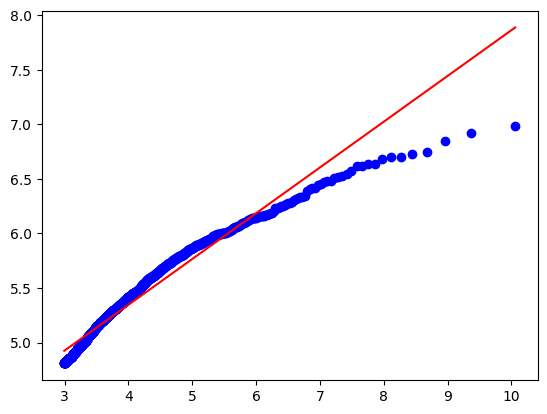

In [ ]:
sample = data_nonzero['diff']
length = len(sample)
sorted_sample = sorted(sample)
level = 0.95
sample_tail = np.array(sorted_sample[int(length*level):])
quant_arr = np.array(list(map(lambda x: -np.log(1 - x), np.arange(level, 1, (1-level)/len(sample_tail)) )))
d = {'target': sample_tail, 'feature': quant_arr}
data_hill = pd.DataFrame(d)
m = smf.ols('np.log(target) ~ feature', data=data_hill)
mfit = m.fit()
plt.plot(quant_arr, np.log(sample_tail), 'bo')
plt.plot(quant_arr, mfit.params[0]+mfit.params[1]*quant_arr, 'r-')

#Test simulation

In [ ]:
#here my test doesn't work, see file Test_discrete
n=2000
step = 10
m=1000
theta = 1
u_1 = -1.65
list_statistic = []
list_k = []
samples = []
for i in range(m):
    samples.append(generate_samples(n, "student", theta))

for k_n in tqdm(range(10, 200, step)):
    counter = 0
    for i in range(m):
        #samples = generate_samples(n, "weibull1", theta)
        statistics = test_statistic(n, int(k_n/2), samples[i], 0.5, "RV-W")
        if statistics < u_1:
            counter += 1./m
    list_statistic.append(counter)
    list_k.append(k_n)

100%|██████████| 19/19 [00:00<00:00, 238.76it/s]


Text(0.5, 0, 'k')

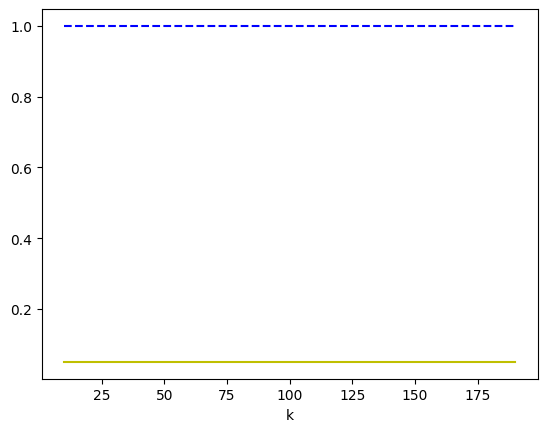

In [ ]:
fig = plt.figure()
list_level = np.zeros(19) + 0.05
list_1 = np.zeros(19)
list_1[0] += 0.2
plt.plot(list_k, list_statistic, 'b--')
plt.plot(list_k, list_level, 'y')
plt.plot(list_k[0], list_1[0], 'black')
plt.xlabel("k")
#fig.savefig('/content/drive/weibull_1.jpg', dpi = 1000)

#Test

In [ ]:
#Some preparations to apply my test
sample = np.array(data_nonzero['diff'])
length = len(sample)
sample_train = sample[:int(length/21)]
new_alphas = list(map(lambda x: 0.95+x*0.00025, range(200)))
length_train = len(sample_train)

u_1 = ss.norm.ppf(0.95)
sig = np.sqrt(1 + np.power(2*np.square(np.log(2)), -1))

#To distinguish between Weibull-type and log-Weibull-type tails set method = "W_LW" and select glob = 3.5
#To distinguish between log-Weibull-type and Pareto-like tails set method = "LW_Pareto" and select glob = 1.1
method = "RV_W"
glob = 0.3

array = np.arange(0.005, 0.05, 0.0025)
array_back = np.ones(len(array)) - array
array_length = np.array(list(map(lambda x: int(length_train*x), array)))
length_train

1111

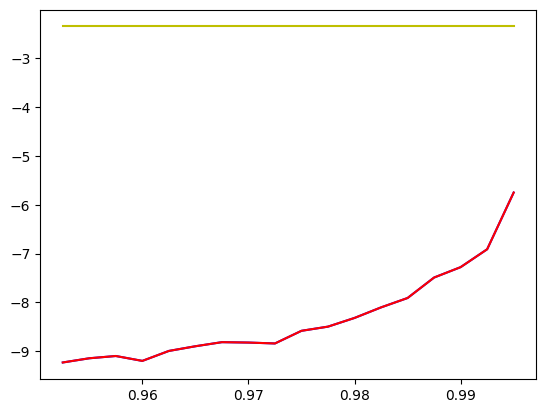

In [ ]:
test_statistic_list = np.array(list(map(lambda x: test_statistic(length_train, int(x/2), sorted(sample_train), glob, method), array_length)))
test_statistic_list1 = np.array(list(map(lambda x: calculate_statistic_test(length_train, int(x/2), "loc-scale", sorted(sample_train), 'RV-W', glob), array_length)))
plt.plot(array_back, -sig*u_1*np.ones(len(array)), 'y-')
plt.plot(array_back, test_statistic_list, 'b-')
plt.plot(array_back, test_statistic_list, 'r-')

#Extrapolation (application of the block quantiles method and its comparison with GPD+MLE)

In [162]:
#Some preparations
#sample = list(data_nonzero['diff'])
#random.shuffle(sample)
sample = data_nonzero['diff']
length = len(sample)
sample_train = sample[:int(length/11)]
sample_test = sample[int(length/11):]
length_test = len(sample_test)
confidence = 0.95 #for CI
new_alphas = list(map(lambda x: 0.98+x*0.0001, range(190)))
new_alphas_train = list(map(lambda x: 0.90+x*0.001, range(100)))
sorted_sample_train = sorted(sample_train)
sorted_sample_test = sorted(sample_test)
empirical_quantiles = list(map(lambda x: sorted_sample_test[int(length_test*x)-1], new_alphas))

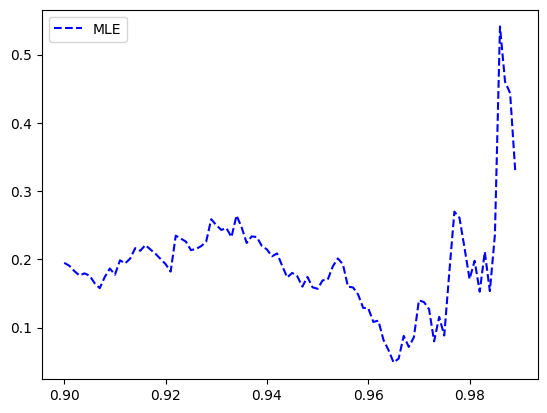

In [163]:
#Here we find the interval of stability of the EVI estimator to select the threshold

#est_hill = list(map(lambda x: hill_estimator(sample, 1-x), new_alphas_train))
#est_moment = list(map(lambda x: moment_estimator(sample, 1-x), new_alphas_train))
est_mle = list(map(lambda x: mle_estimator(sample_train, 1-x)[0], new_alphas_train[:90]))
#est_CIup_mle = list(map(lambda x: mle_estimator(sample_train, 1-x)[0] + mle_bound(sample_train, 1-x), new_alphas_train[:90]))
#est_CIdown_mle = list(map(lambda x: mle_estimator(sample_train, 1-x)[0] - mle_bound(sample_train, 1-x), new_alphas_train[:90]))
#est_LWmle = list(map(lambda x: MLE_logWeibull2(sample, 1-x, 'Cobyla')[1], new_alphas_train[:90]))
#est_intervals = list(map(lambda x: intervals_estimator(sample_train, 1-x), new_alphas_train))
#plt.plot(new_alphas_train, est_hill, 'r--', label = 'Hill')
#plt.plot(new_alphas_train, est_moment, 'g--', label = 'Moment')
plt.plot(new_alphas_train[:90], est_mle, 'b--', label = 'MLE')
#plt.plot(new_alphas_train[:90], est_CIup_mle, 'r:', label = 'MLE_bound')
#plt.plot(new_alphas_train[:90], est_CIdown_mle, 'r:', label = 'MLE_bound')
#plt.plot(new_alphas_train[:90], est_LWmle, 'b--', label = 'MLE_logW')
#plt.plot(new_alphas_train, est_intervals, 'r--', label = 'Intervals')
plt.legend()

In [38]:
len(sample_train)

1111

In [164]:
ratio_of_high_values = 0.07
length_train = len(sample_train)
N_for_check = 1
evi = hill_estimator(sample_train, ratio_of_high_values)
evi_moment = moment_estimator(sample_train, ratio_of_high_values)
sigma = sigma_estimator(sample_train, ratio_of_high_values)
theta = 1 #intervals_estimator(sample, ratio_of_high_values)
evi_pmle, loc_pmle, sigma_pmle = mle_estimator(sample_train, ratio_of_high_values)
threshold = sorted_sample_train[int(length_train*(1 - ratio_of_high_values))]
estimated_quantiles_classical = list(map(lambda x: quantile_classical(evi, sigma, theta, ratio_of_high_values, threshold, x, N_for_check), new_alphas))
moment_quantiles = list(map(lambda x: quantile_classical(evi_moment, sigma, theta, ratio_of_high_values, threshold, x, N_for_check), new_alphas))
estimated_genpareto = list(map(lambda x: quantile_classical(evi_pmle, sigma_pmle, theta, ratio_of_high_values, threshold, x, N_for_check), new_alphas))

In [119]:
mle_boot_bounds = mle_bounds_bootstrap(sample_train, ratio_of_high_values, confidence)
bup = sigma_pmle*mle_boot_bounds[0]
bdown = sigma_pmle*mle_boot_bounds[1]
boot_bound_up = list(map(lambda x: bup*q_gamma(evi_pmle, ratio_of_high_values, x), new_alphas))
boot_bound_down = list(map(lambda x: bdown*q_gamma(evi_pmle, ratio_of_high_values, x), new_alphas))

In [165]:
#Setting hyperparameters for the block quantiles method
block_min = int(np.power(length_train, 1/4))
block_max = int(np.power(length_train, 3/4))
number_block = int(2*np.sqrt(block_max - block_min))

alpha_min = 0.01
alpha_max = 0.99
rho = 2

In [166]:
#Block quantiles method for Weibull model
feature1, target1 = generate_model(sample_train, alpha_min, alpha_max, block_min, block_max, number_block, ratio_of_high_values, threshold, is_threshold = False)

estimated_quantiles2, sig1, starting_theta = LS(feature1, target1, 'W', N_for_check, new_alphas)
quantiles_theil1, sig2, starting_theta2 = Theil(feature1, target1, 'W', N_for_check, new_alphas)
#quantiles_cobyla, res_cob = Cobyla(feature1, target1, 'W', N_for_check, new_alphas, starting_theta)
quantiles_adam, res_adam = Adam(feature1, target1, 'W', N_for_check, new_alphas, starting_theta, rho)
#starting_theta, starting_theta2, res_cob, res_adam

In [55]:
#Quantile regression
quantiles_ls_down = QuantLS(feature1, target1, 'W', 0.025, N_for_check, new_alphas)
quantiles_ls_up = QuantLS(feature1, target1, 'W', 0.975, N_for_check, new_alphas)
quantiles_adam_up = QuantAdam(feature1, target1, 'W', 0.975, N_for_check, new_alphas, starting_theta, rho)
quantiles_adam_down = QuantAdam(feature1, target1, 'W', 0.025, N_for_check, new_alphas, starting_theta, rho)
quantiles_theil_up = QuantTheil(feature1, target1, 'W', 0.975, N_for_check, new_alphas)
quantiles_theil_down = QuantTheil(feature1, target1, 'W', 0.025, N_for_check, new_alphas)

In [ ]:
consensus = (quantiles_adam + quantiles_theil1 + estimated_quantiles2)/3.
#consensus1 = (quantiles_cobyla + quantiles_theil1 + estimated_quantiles2)/3.
#consensus2 = (quantiles_cobyla + quantiles_theil1 + estimated_quantiles2 + quantiles_adam)/4.
consensus_down = (quantiles_adam + quantiles_theil_down + quantiles_ls_down)/3.
consensus_up = (quantiles_adam_up + quantiles_theil_up + quantiles_ls_up)/3.
plt.plot(empirical_quantiles, empirical_quantiles, 'bo', label = "Empirical")
#plt.plot(np.array(empirical_quantiles), np.array(estimated_genpareto) - np.array(empirical_quantiles), 'r-.', label = "MLE")
plt.plot(np.array(empirical_quantiles), np.array(estimated_genpareto), 'r-.', label = "MLE")
plt.plot(empirical_quantiles, np.array(estimated_genpareto) - np.array(boot_bound_up), 'r:', label = "MLE 90% CI")
plt.plot(empirical_quantiles, np.array(estimated_genpareto) - np.array(boot_bound_down), 'r:')
#plt.plot(empirical_quantiles, estimated_quantiles_classical, 'g-.')
#plt.plot(empirical_quantiles, moment_quantiles, 'y:')
#plt.plot(empirical_quantiles, quantiles_adam, 'm--', label = "Adam")
#plt.plot(empirical_quantiles, quantiles_adam_up, 'g:', label = "Adam 90% CI")
#plt.plot(empirical_quantiles, quantiles_adam_down, 'g:')
#plt.plot(empirical_quantiles, quantiles_cobyla, 'k--', label = "Cobyla")
#plt.plot(empirical_quantiles, estimated_quantiles2, 'y--', label = "LS")
plt.plot(empirical_quantiles, consensus_up, 'g:', label = "Consensus 90% CI")
plt.plot(empirical_quantiles, consensus_down, 'g:')
#plt.plot(empirical_quantiles, quantiles_theil1, 'g--', label = "Theil")
plt.plot(empirical_quantiles, consensus, 'g--', label = "Consensus")
#plt.plot(empirical_quantiles, consensus1, ':', label = "Consensus_Cob")
plt.legend()

In [ ]:
consensus = (quantiles_adam + quantiles_theil1 + estimated_quantiles2)/3.
consensus_down = (quantiles_adam + quantiles_theil_down + quantiles_ls_down)/3.
consensus_up = (quantiles_adam_up + quantiles_theil_up + quantiles_ls_up)/3.
plt.plot(empirical_quantiles, np.zeros(len(empirical_quantiles)), 'b-', label = "Empirical")
plt.plot(np.array(empirical_quantiles), np.array(estimated_genpareto) - np.array(empirical_quantiles), 'r-.', label = "MLE")
plt.plot(np.array(empirical_quantiles), np.array(estimated_genpareto) - np.array(boot_bound_up) - np.array(empirical_quantiles), 'r:', label = "MLE 95% CI")
plt.plot(np.array(empirical_quantiles), np.array(estimated_genpareto) - np.array(boot_bound_down) - np.array(empirical_quantiles), 'r:')#, label = "MLE_boot bound")
#plt.plot(np.array(empirical_quantiles), np.array(estimated_genpareto), 'r-.', label = "MLE")
#plt.plot(empirical_quantiles, estimated_quantiles_classical, 'g-.')
#plt.plot(empirical_quantiles, moment_quantiles, 'y:')
#plt.plot(np.array(empirical_quantiles), np.array(quantiles_adam) - np.array(empirical_quantiles), 'g-.', label = "Adam")
#plt.plot(np.array(empirical_quantiles), np.array(quantiles_adam_up) - np.array(empirical_quantiles), 'g:', label = "Adam 90% CI")
#plt.plot(np.array(empirical_quantiles), np.array(quantiles_adam_down) - np.array(empirical_quantiles), 'g:')
#plt.plot(np.array(empirical_quantiles), np.array(quantiles_cobyla) - np.array(empirical_quantiles), 'k:', label = "Cobyla")
#plt.plot(np.array(empirical_quantiles), np.array(estimated_quantiles2) - np.array(empirical_quantiles), 'y-.', label = "LS")
#plt.plot(np.array(empirical_quantiles), np.array(quantiles_down) - np.array(empirical_quantiles), 'y:', label = "LS 90% CI")
#plt.plot(np.array(empirical_quantiles), np.array(quantiles_up) - np.array(empirical_quantiles), 'y:')
#plt.plot(empirical_quantiles, quantiles_MLE_Weibull, 'y:', label = "LS")
#plt.plot(np.array(empirical_quantiles), np.array(quantiles_theil1) - np.array(empirical_quantiles), 'g:', label = "Theil")
plt.plot(np.array(empirical_quantiles), np.array(consensus) - np.array(empirical_quantiles), 'c--', label = "Consensus")
plt.plot(np.array(empirical_quantiles), np.array(consensus_up) - np.array(empirical_quantiles), 'c:', label = "Consensus 95% CI")
plt.plot(np.array(empirical_quantiles), np.array(consensus_down) - np.array(empirical_quantiles), 'c:') #label = "Consensus_Cob+Ad")
plt.legend()

In [167]:
CvM(empirical_quantiles, consensus), CvM(empirical_quantiles, estimated_genpareto)

(9.254944598337943, 0.9932271468144052)

#Seasons

In [ ]:
data_nonzero_winter = data_nonzero[(data_nonzero['day']<60)|(data_nonzero['day']>334)]
X = data_nonzero_winter[['year', 'day']]
y = data_nonzero_winter['prcp']

gam = GAM(s(0)+s(1), distribution='gamma', link='identity').fit(X, y)
gam.summary()

data_nonzero_winter['diff'] = y - gam.predict(X)

In [ ]:
data_nonzero_summer = data_nonzero[(data_nonzero['day']>151)&(data_nonzero['day']<244)]
X = data_nonzero_summer[['year', 'day']]
y = data_nonzero_summer['prcp']

gam = GAM(s(0)+s(1), distribution='gamma', link='identity').fit(X, y)
gam.summary()

data_nonzero_summer['diff'] = y - gam.predict(X)

In [ ]:
#Some preparations
#sample = list(data_nonzero['diff'])
#random.shuffle(sample)
sample_winter = data_nonzero_winter['diff']
length_winter = len(sample_winter)
sample_winter_train = sample_winter[:int(length_winter/5.)]
sample_winter_test = sample_winter[int(length_winter/5.):]
length_winter_test = len(sample_winter_test)
new_alphas = list(map(lambda x: 0.98+x*0.0001, range(190)))
new_alphas_train = list(map(lambda x: 0.90+x*0.001, range(100)))
sorted_sample_winter_train = sorted(sample_winter_train)
sorted_sample_winter_test = sorted(sample_winter_test)
empirical_quantiles_winter = list(map(lambda x: sorted_sample_winter_test[int(length_winter_test*x)-1], new_alphas))

sample_summer = data_nonzero_summer['diff']
length_summer = len(sample_summer)
sample_summer_train = sample_summer[:int(length_summer/5.)]
sample_summer_test = sample_summer[int(length_summer/5.):]
length_summer_test = len(sample_summer_test)
new_alphas = list(map(lambda x: 0.98+x*0.0001, range(190)))
new_alphas_train = list(map(lambda x: 0.90+x*0.001, range(100)))
sorted_sample_summer_train = sorted(sample_summer_train)
sorted_sample_summer_test = sorted(sample_summer_test)
empirical_quantiles_summer = list(map(lambda x: sorted_sample_summer_test[int(length_summer_test*x)-1], new_alphas))

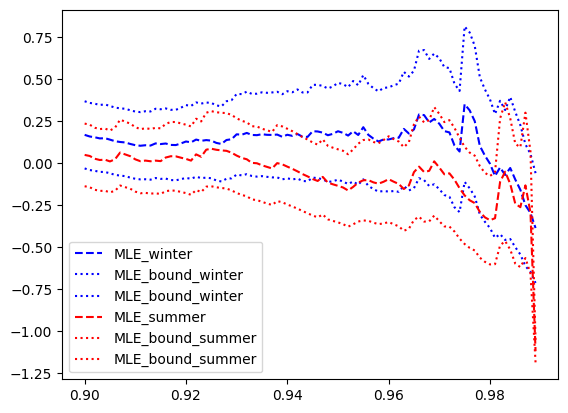

In [ ]:
est_mle = list(map(lambda x: mle_estimator(sample_winter_train, 1-x)[0], new_alphas_train[:90]))
est_CIup_mle = list(map(lambda x: mle_estimator(sample_winter_train, 1-x)[0] + mle_bound(sample_winter_train, 1-x), new_alphas_train[:90]))
est_CIdown_mle = list(map(lambda x: mle_estimator(sample_winter_train, 1-x)[0] - mle_bound(sample_winter_train, 1-x), new_alphas_train[:90]))
plt.plot(new_alphas_train[:90], est_mle, 'b--', label = 'MLE_winter')
plt.plot(new_alphas_train[:90], est_CIup_mle, 'b:', label = 'MLE_bound_winter')
plt.plot(new_alphas_train[:90], est_CIdown_mle, 'b:', label = 'MLE_bound_winter')

est_mle = list(map(lambda x: mle_estimator(sample_summer_train, 1-x)[0], new_alphas_train[:90]))
est_CIup_mle = list(map(lambda x: mle_estimator(sample_summer_train, 1-x)[0] + mle_bound(sample_summer_train, 1-x), new_alphas_train[:90]))
est_CIdown_mle = list(map(lambda x: mle_estimator(sample_summer_train, 1-x)[0] - mle_bound(sample_summer_train, 1-x), new_alphas_train[:90]))
plt.plot(new_alphas_train[:90], est_mle, 'r--', label = 'MLE_summer')
plt.plot(new_alphas_train[:90], est_CIup_mle, 'r:', label = 'MLE_bound_summer')
plt.plot(new_alphas_train[:90], est_CIdown_mle, 'r:', label = 'MLE_bound_summer')

plt.legend()

#Comparison with metastatistical

In [ ]:
data = pd.read_csv("/content/USW00014845.csv", sep = ",", index_col=False)

#Choice of the longest row of "good" years
year_first, year_final = prcp_check(data)

#Removing all 29 February
arr = []
for i in range(len(data)):
  if data['DATE'][i][5:10] == '02-29':
    arr.append(i)

data = data.drop(labels = arr, axis = 0)

#Removing bad years
flag = 0
while int(data['DATE'][data.index[flag]][0:4]) < year_first:
    flag += 1
flag1 = len(data['DATE']) -1
while int(data['DATE'][data.index[flag1]][0:4]) != year_final:
    flag1 -= 1

arr = data.index[flag:flag1+1]
date = data['DATE'][arr]
prcp = data['PRCP'][arr]

#Extracting years and numbers of a day in year from date
year = np.array(list(map(lambda x: int(date[x][0:4]), arr)))
day_in_year = np.array(list(map(lambda x: month_day_to_number(int(date[x][5:7]), int(date[x][8:10])), arr)))

#Dataset for applying GAM
d = {'prcp': prcp, 'year': year, 'day': day_in_year}
data_prcp = pd.DataFrame(d)
data_prcp['prcp'] = data_prcp['prcp'].fillna(0)

#removing zeros
data_nonzero = data_prcp[data_prcp['prcp']>0]

In [ ]:
rat = 0.1
year_bound = year_first + int(rat*(year_final - year_first))

data_prcp_train = data_prcp[data_prcp['year'] < year_bound + 1]
data_nonzero_train = data_nonzero[data_nonzero['year'] < year_bound + 1]

n_years = year_final - year_bound
alphas = np.arange(1/(n_years+1), 1, 1/(n_years+1))
years_test = np.arange(year_bound + 1, year_final+1, 1)

max_years = np.array(list(map(lambda x: max(data_prcp['prcp'][data_prcp['year'] == x]), years_test)))
empirical_quantiles = np.array(sorted(max_years))

In [ ]:
quantiles_LS = np.array(quantiles_cdf(data_prcp_train, 'LS', alphas))
quantiles_Theil = np.array(quantiles_cdf(data_prcp_train, 'Theil', alphas))
quantiles_Adam = np.array(quantiles_cdf(data_prcp_train, 'Adam', alphas))
#quantiles_Cobyla = quantiles_cdf(data_prcp_train, 'Cobyla', alphas)
#quantiles_consensus = np.array((quantiles_LS + quantiles_Theil)/2.)
quantiles_consensus = np.array((quantiles_LS + quantiles_Theil + quantiles_Adam)/3.)
quantiles_meta = np.array(metasta(data_nonzero_train, 'PWM', alphas))

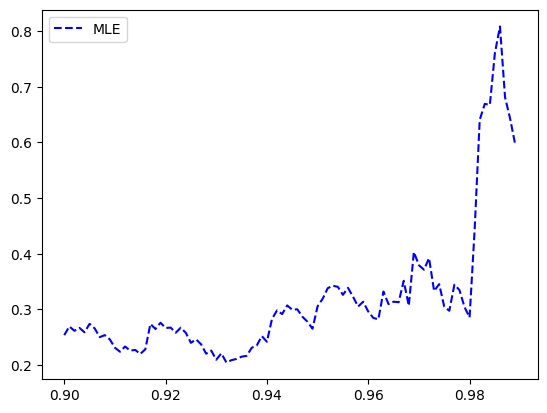

In [ ]:
nonzero_prcp = data_nonzero_train['prcp'].values
new_alphas_train = list(map(lambda x: 0.90+x*0.001, range(90)))
est_mle = list(map(lambda x: mle_estimator(nonzero_prcp, 1-x)[0], new_alphas_train))
#est_CIup_mle = list(map(lambda x: mle_estimator(nonzero_prcp, 1-x)[0] + mle_bound(nonzero_prcp, 1-x), new_alphas_train))
#est_CIdown_mle = list(map(lambda x: mle_estimator(nonzero_prcp, 1-x)[0] - mle_bound(nonzero_prcp, 1-x), new_alphas_train))
plt.plot(new_alphas_train[:90], est_mle, 'b--', label = 'MLE')
#plt.plot(new_alphas_train[:90], est_CIup_mle, 'r:', label = 'MLE_bound')
#plt.plot(new_alphas_train[:90], est_CIdown_mle, 'r:', label = 'MLE_bound')
plt.legend()

In [ ]:
ratio_of_high_values = 0.06
evi_pmle, loc_pmle, sigma_pmle = mle_estimator(nonzero_prcp, ratio_of_high_values)
nonzero_per_year, ratio = index_of_dispersion(data_nonzero_train, ratio_of_high_values)
m1 = np.mean(nonzero_per_year)
s2 = np.var(nonzero_per_year)
p = m1/s2
r = np.power(m1,2)/(s2 - m1)

ratio1 = ratio_of_high_values*len(nonzero_prcp)/len(data_prcp_train['prcp'].values)
theta = intervals_estimator(data_prcp_train['prcp'].values, ratio1)
#sample_egev = sorted(nonzero_prcp)
#n_egev = len(sample_egev)
#level_egev = sample_egev[int(n*(1 - ratio_of_high_values))]
level = np.quantile(nonzero_prcp, 1 - ratio_of_high_values)
#quantiles_egev = np.array(quantile_egev(r, p, evi_pmle, sigma_pmle, level, alphas))
quantiles_classical = np.array(list(map(lambda x: quantile_classical(evi_pmle, sigma_pmle, theta, ratio1, level, x, 365), alphas)))

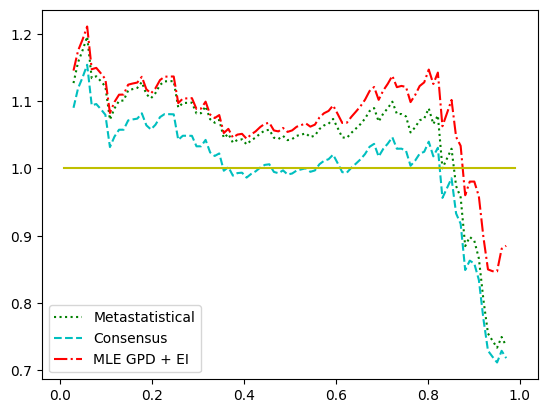

In [ ]:
#plt.plot(empirical_quantiles, alphas, 'bo', label = "Empirical")
#plt.plot(quantiles_Adam, alphas, 'r-.', label = "Adam")
#plt.plot(quantiles_meta, alphas, 'k-.', label = "Metastat")
#plt.plot(quantiles_LS, alphas, 'y:', label = "LS")
#plt.plot(quantiles_Theil, alphas, 'g:', label = "Theil")
#plt.plot(quantiles_consensus, alphas, ':', label = "Consensus")
#plt.plot(alphas, quantiles_Adam/empirical_quantiles, 'r-.', label = "Adam")
plt.plot( alphas[2:n_years-2], quantiles_meta[2:n_years-2]/empirical_quantiles[2:n_years-2], 'g:', label = "Metastatistical")
#plt.plot( alphas[2:n_years-2], quantiles_LS[2:n_years-2]/empirical_quantiles[2:n_years-2], 'b--', label = "LS")
#plt.plot( alphas, quantiles_LS/empirical_quantiles, 'y:', label = "LS")
#plt.plot( alphas[2:n_years-2], quantiles_Theil[2:n_years-2]/empirical_quantiles[2:n_years-2], 'c--', label = "Theil")
#plt.plot( alphas[2:n_years-2], quantiles_Adam[2:n_years-2]/empirical_quantiles[2:n_years-2], 'y--', label = "Adam")
plt.plot( alphas[2:n_years-2], quantiles_consensus[2:n_years-2]/empirical_quantiles[2:n_years-2], 'c--', label = "Consensus")
#plt.plot( alphas[1:n_years-1], quantiles_egev[1:n_years-1]/empirical_quantiles[1:n_years-1], 'r-.', label = "EGEV")
plt.plot( alphas[2:n_years-2], quantiles_classical[2:n_years-2]/empirical_quantiles[2:n_years-2], 'r-.', label = "MLE GPD + EI")
#plt.plot(alphas, quantiles_consensus/empirical_quantiles, ':', label = "Consensus")
plt.plot(alphas, np.ones(len(alphas)), 'y-')
plt.legend()

#Performance of block quantiles method for generated iid and stationary data

In [ ]:
N = 1000
N_for_check = 1
#Possible options for stationary sequences: "ARc", "AR2", "ARSt", "MA", "MA_LN", "Garch", "GarchGauss", "MM1", "MM_Gamma", "MM_Exp",
#"ARMAX", "ARMAX_LN", "Example", "LindleyBurr", "LindleyLN", "Metropolis"
type_series = "Garch"
type_iid = "weibull"
theta = 1.5
EI = 1
rho = 2
confidence_level = 0.95

ratio_of_high_values = 0.05
alpha_min = 0.01
alpha_max = 0.99
block_min = int(np.power(N, 1/4))
block_max = int(np.power(N, 3/4))
number_block = int(2*np.sqrt(block_max - block_min))

new_alphas = list(map(lambda x: 0.99+x*0.0005, range(20)))
real_quantiles = ss.expon.ppf(new_alphas)

In [ ]:
#It's for stationary time series;
#iterations = 10000
#sample_max = list(map(lambda x: np.max(generate_time_series(N_for_check, type_series)), range(iterations)))
#new_alphas = list(map(lambda x: 0.8+x*0.01, range(20)))
#sample_max = sorted(sample_max)

#empirical_quantiles = list(map(lambda x: sample_max[int(iterations*x)-1], new_alphas))

#This is for iid samples
iterations = 1000000
new_alphas = list(map(lambda x: 0.98+x*0.001, range(20)))
sample_big = generate_samples(iterations, type_iid, theta)
real_quantiles = list(map(lambda x: np.quantile(sample_big, x), new_alphas))

In [ ]:
N_iter = 1000
lna = len(new_alphas)
quantiles_mle = np.zeros(lna*N_iter).reshape((N_iter, lna))
quantiles_consensus = np.zeros(lna*N_iter).reshape((N_iter, lna))

for i in tqdm(range(N_iter)):

  sample = np.array(generate_samples(N, type_iid, theta))
  sorted_sample = sorted(sample)
  evi_pmle, loc_pmle, sigma_pmle = mle_estimator(sorted_sample, ratio_of_high_values)
  threshold = np.quantile(sorted_sample, 1 - ratio_of_high_values)
  quantiles_mle[i] = list(map(lambda x: quantile_classical(evi_pmle, sigma_pmle, EI, ratio_of_high_values, threshold, x, N_for_check), new_alphas))

  feature1, target1 = generate_model(sample, alpha_min, alpha_max, block_min, block_max, number_block, ratio_of_high_values, threshold, is_threshold = False)

  estimated_quantiles2, sig1, starting_theta = LS(feature1, target1, 'W', N_for_check, new_alphas)
  #quantiles_theil1, sig2, starting_theta2 = Theil(feature1, target1, 'W', N_for_check, new_alphas)
  quantiles_adam, res_adam = Adam(feature1, target1, 'W', N_for_check, new_alphas, starting_theta, rho)
  quantiles_consensus[i] = (quantiles_adam + quantiles_theil1 + estimated_quantiles2)/3.
  quantiles_consensus[i] = estimated_quantiles2

  2%|▏         | 18/1000 [00:27<24:59,  1.53s/it]


KeyboardInterrupt: 

In [ ]:
temp1 = np.transpose(quantiles_consensus)
temp2 = np.transpose(quantiles_mle)
consensus_up = np.zeros(lna)
consensus_down = np.zeros(lna)
consensus_mean = np.zeros(lna)
mle_up = np.zeros(lna)
mle_down = np.zeros(lna)
mle_mean = np.zeros(lna)

for i in range(lna):
    consensus_up[i] = np.quantile(temp1[i], (confidence_level+1)/2)
    consensus_down[i] = np.quantile(temp1[i], (1 - confidence_level)/2)
    consensus_mean[i] = np.median(temp1[i])
    mle_up[i] = np.quantile(temp2[i], (confidence_level+1)/2)
    mle_down[i] = np.quantile(temp2[i], (1 - confidence_level)/2)
    mle_mean[i] = np.median(temp2[i])

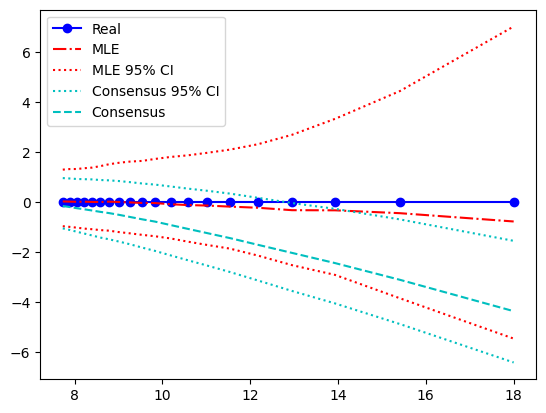

In [ ]:
plt.plot(real_quantiles, np.zeros(lna), 'bo-', label = "Real")
plt.plot()
#plt.plot(np.array(empirical_quantiles), np.array(estimated_genpareto) - np.array(empirical_quantiles), 'r-.', label = "MLE")
plt.plot(np.array(real_quantiles), np.array(mle_mean)-np.array(real_quantiles), 'r-.', label = "MLE")
plt.plot(np.array(real_quantiles), np.array(mle_up)-np.array(real_quantiles), 'r:', label = "MLE 95% CI")
plt.plot(np.array(real_quantiles), np.array(mle_down)-np.array(real_quantiles), 'r:')
plt.plot(np.array(real_quantiles), np.array(consensus_up)-np.array(real_quantiles), 'c:', label = "Consensus 95% CI")
plt.plot(np.array(real_quantiles), np.array(consensus_down)-np.array(real_quantiles), 'c:')
plt.plot(np.array(real_quantiles), np.array(consensus_mean)-np.array(real_quantiles), 'c--', label = "Consensus")
plt.legend()

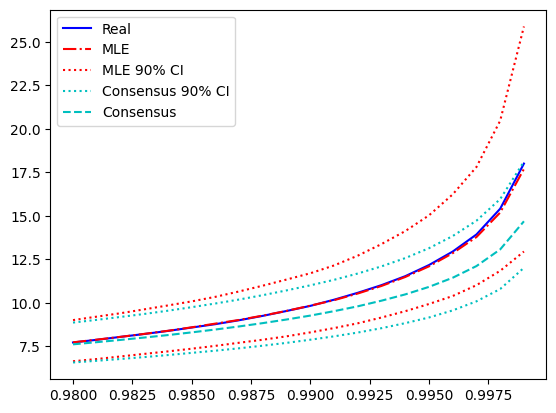

In [ ]:
plt.plot(new_alphas, np.array(real_quantiles), 'b-', label = "Real")
#plt.plot(np.array(empirical_quantiles), np.array(estimated_genpareto) - np.array(empirical_quantiles), 'r-.', label = "MLE")
plt.plot(new_alphas, np.array(mle_mean), 'r-.', label = "MLE")
plt.plot(new_alphas, np.array(mle_up), 'r:', label = "MLE 90% CI")
plt.plot(new_alphas, np.array(mle_down), 'r:')
plt.plot(new_alphas, consensus_up, 'c:', label = "Consensus 90% CI")
plt.plot(new_alphas, consensus_down, 'c:')
plt.plot(new_alphas, consensus_mean, 'c--', label = "Consensus")
plt.legend()